In [100]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.datamodules.components import chipmultilabel
from earthtext.osm.multilabel import kvmerged
from joblib import Parallel, delayed
from importlib import reload
reload(chipmultilabel)

<module 'earthtext.datamodules.components.chipmultilabel' from '/home/ubuntu/earth-text/src/earthtext/datamodules/components/chipmultilabel.py'>

In [1]:
from earthtext.search import search

hola


# load osm encoder model

In [2]:
model_ckpt_fname = "/opt/data/models/osm_emcoder_2024-04-25_12:01-training.ckpt"
model_conf_fname = model_ckpt_fname[:-5] + ".yaml"

if not os.path.isfile(model_ckpt_fname) or not os.path.isfile(model_conf_fname):
    raise ValueError("cannot find model or conf")

In [3]:
conf = OmegaConf.load(model_conf_fname)
m = hydra.utils.instantiate(conf.model)
m.load_state_dict(torch.load(model_ckpt_fname))

<All keys matched successfully>

## setup dataloader

In [4]:
dl = hydra.utils.instantiate(conf.dataloader)

2024-04-25 23:37:58.799 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1041 - checking chip files for train split
100% (60396 of 60396) |##################| Elapsed Time: 0:00:03 Time:  0:00:030000
2024-04-25 23:38:01.847 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1045 - read train split with 60295 chip files (out of 60396)
2024-04-25 23:38:01.847 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1050 - max cache size is -1
2024-04-25 23:38:02.566 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1041 - checking chip files for val split
100% (12304 of 12304) |##################| Elapsed Time: 0:00:00 Time:  0:00:000000
2024-04-25 23:38:03.182 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1045 - read val split with 12288 chip files (out of 12304)
2024-04-25 23:38:03.183 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:1050 - max cache size is -1
2024-04-

# retrieve everything: osmvectors, embeddings and predictions

In [5]:
def get_top10_sim(vectorbase, query):
    ntargets = (vectorbase.T / np.linalg.norm(vectorbase,axis=1)).T
    nquery   = query / np.linalg.norm(query)
    sims = ntargets.dot(nquery)
    top10idxs = np.argsort(sims)[-10:]
    return top10idxs


def get_targets_and_predictions(dataloader):
    targets = []
    predictions = []
    inputs = []
    chip_ids = []

    for batch in pbar(dataloader):
        t = batch['embedding']
        o = m(batch)
        x = m.make_input(batch)
    
        for ti in t.detach().numpy():
            targets.append(ti)
    
        for oi in o.detach().numpy():
            predictions.append(oi)

        for xi in x.detach().numpy():
            inputs.append(xi)
        
        for ci in batch['chip_id']:
            chip_ids.append(ci)

    targets = np.r_[targets]
    predictions = np.r_[predictions]
    inputs = np.r_[inputs]
    return targets, predictions, inputs, chip_ids


In [7]:
# load all data from selected split

dl.disable_chip_loading()

def similarity(t1,t2):
    
    t1 = t1 / np.linalg.norm(t1)
    t2 = t2 / np.linalg.norm(t2)
    return t1.dot(t2) 

def get_similarity_sorted_indexes(vectorbase, query):
    ntargets = (vectorbase.T / np.linalg.norm(vectorbase,axis=1)).T
    nquery   = query / np.linalg.norm(query)
    sims = ntargets.dot(nquery)

    sorted_idxs = np.argsort(sims)[::-1]
    return sorted_idxs, sims[sorted_idxs]

unnormalize_counts = lambda x: (x*chipmultilabel.ohecount_std[conf.model.osm_tags_indexes] + chipmultilabel.ohecount_mean[conf.model.osm_tags_indexes]).astype(int)
unnormalize_areas  = lambda x: (x*chipmultilabel.ohearea_std[conf.model.osm_tags_indexes] + chipmultilabel.ohearea_mean[conf.model.osm_tags_indexes]).astype(int)
unnormalize_lengths = lambda x: (x*chipmultilabel.ohelength_std[conf.model.osm_tags_indexes] + chipmultilabel.ohelength_mean[conf.model.osm_tags_indexes]).astype(int)


dataloaders = {
    'train': dl.train_dataloader(),
    'test': dl.test_dataloader(),
    'val': dl.val_dataloader()
}

inference_items = {}
for k,d in dataloaders.items(): 
    d.dataset.normalize_input = True
    d.dataset.get_chip_id = True
    t,p,i,c = get_targets_and_predictions(d)
    inference_items[k] = {    
        'targets': t,
        'predictions': p,
        'inputs': i,
        'chip_ids': c
    }


100% (1885 of 1885) |####################| Elapsed Time: 0:00:17 Time:  0:00:170001
100% (420 of 420) |######################| Elapsed Time: 0:00:06 Time:  0:00:060000
100% (384 of 384) |######################| Elapsed Time: 0:00:04 Time:  0:00:040000


In [8]:
pd.DataFrame({k: {kk:vv.shape for kk,vv in v.items() if kk!='chip_ids'} for k,v in inference_items.items()})

,train,test,val
targets,"(60295, 768)","(13411, 768)","(12288, 768)"
predictions,"(60295, 768)","(13411, 768)","(12288, 768)"
inputs,"(60295, 105)","(13411, 105)","(12288, 105)"


# compute topk_precision_mean

In [92]:
# function to call in parallel
def _compute_topk_precision_mean(query_idx, query_source, search_target, min_counts=1, min_areas=None, mink=10, maxk=100):


    if (min_counts is not None) + (min_areas is not None) != 1:
        raise ValueError("must set exactly one of 'min_counts' and 'min_areas'")
    
    qidx = query_idx
    
    # get predicted embedding
    query_osm_vector = inference_items[query_source]['inputs'][qidx]
    query_predicted_embedding = inference_items[query_source]['predictions'][qidx]

    # make search
    sorted_search_result_idxs, sorted_search_result_scores  = get_similarity_sorted_indexes(inference_items[search_target]['targets'], query_predicted_embedding)
    sorted_search_result_osmvectors = inference_items[search_target]['inputs'][sorted_search_result_idxs]

    # split counts, areas and lengths and unnormalize osmvectors (to have actual numbers back)
    n_osm_classes = len(conf.model.osm_tags_indexes)
    query_osm_vector_counts = query_osm_vector[:n_osm_classes]
    query_osm_vector_areas  = query_osm_vector[n_osm_classes:n_osm_classes*2]
    query_osm_vector_lengths = query_osm_vector[n_osm_classes*2:]
    
    sorted_search_result_osmvectors_counts  = sorted_search_result_osmvectors[:, :n_osm_classes]
    sorted_search_result_osmvectors_areas   = sorted_search_result_osmvectors[:, n_osm_classes:n_osm_classes*2]
    sorted_search_result_osmvectors_lengths = sorted_search_result_osmvectors[:, n_osm_classes*2:]
    
    usorted_search_result_osmvectors_counts = unnormalize_counts(sorted_search_result_osmvectors_counts)
    usorted_search_result_osmvectors_areas = unnormalize_areas(sorted_search_result_osmvectors_areas)
    usorted_search_result_osmvectors_lengths = unnormalize_lengths(sorted_search_result_osmvectors_lengths)
    
    uquery_osm_vector_counts = unnormalize_counts(query_osm_vector_counts)
    uquery_osm_vector_areas = unnormalize_areas(query_osm_vector_areas)
    uquery_osm_vector_lengths = unnormalize_lengths(query_osm_vector_lengths)

    # filter for presence of classes both in the response and the query 
    if min_counts is not None:
        osmclasses_in_query = np.argwhere(uquery_osm_vector_counts>=min_counts) [:,0]
    elif min_areas is not None:
        osmclasses_in_query = np.argwhere(uquery_osm_vector_areas>=min_areas) [:,0]
        
    osmquery_classes_present_in_response = (usorted_search_result_osmvectors_counts[:, osmclasses_in_query]>1).astype(int)
    
    # average precision per osm class in top-k results
    topk_precision = np.r_[[osmquery_classes_present_in_response[:k].mean(axis=0) for k in range(mink, maxk+1)]]
    topk_precision_mean = {k:v for k,v in zip(osmclasses_in_query, topk_precision.mean(axis=0))}

    return topk_precision_mean

In [104]:
len(inference_items['test']['inputs'])

13411

In [112]:
query_source = 'test'
search_target = 'train'

def compute_topk_precision_mean(query_source, search_target, min_counts=None, min_areas=None, mink=10, maxk=100, n_samples=1000, plot=False):
    if n_samples is None:
        n_samples = len(inference_items[query_source]['inputs'])
    topk = Parallel(n_jobs=-1, verbose=1)(delayed(_compute_topk_precision_mean)(query_idx=qidx, 
                                                                               query_source=query_source, 
                                                                               search_target=search_target, 
                                                                               min_counts=min_counts,
                                                                               min_areas=min_areas,
                                                                               mink=mink, 
                                                                               maxk=maxk)\
                                           for qidx in np.random.permutation(len(inference_items[query_source]['inputs']))[:n_samples])
    topk = pd.DataFrame(topk).fillna(-1)
    topk = topk[sorted(topk.columns)]
    topk_summary = pd.DataFrame([{c: topk[topk[c]>=0][c].values.mean() for c in topk.columns}]).T
    topk_summary.index = [kvmerged.inverse_codes[c] for c in topk_summary.index]

    if plot:
        topk_summary.plot(kind='bar', figsize=(20,3))
        plt.grid(); plt.ylim(0,1)   
        n = len(inference_items[query_source]['inputs'])
        if n_samples is None:
            qstext = f"using all {n} samples"
        else:
            qstext = f"using {n_samples} samples out of {n}"

        n = len(inference_items[search_target]['inputs'])
        sttext = f"{n} data points"
        
        title = f"top k precision mean for k between {mink} and {maxk} :: query source {query_source} ({qstext}) :: search target {search_target} ({sttext})"
        if min_counts is not None:
            title += f" :: min_counts {min_counts}"
        if min_areas is not None:
            title += f" :: min_areas {min_areas}"
        plt.title(title)
        
    return topk_summary
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 7136 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 8386 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 11186 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 12736 tasks    

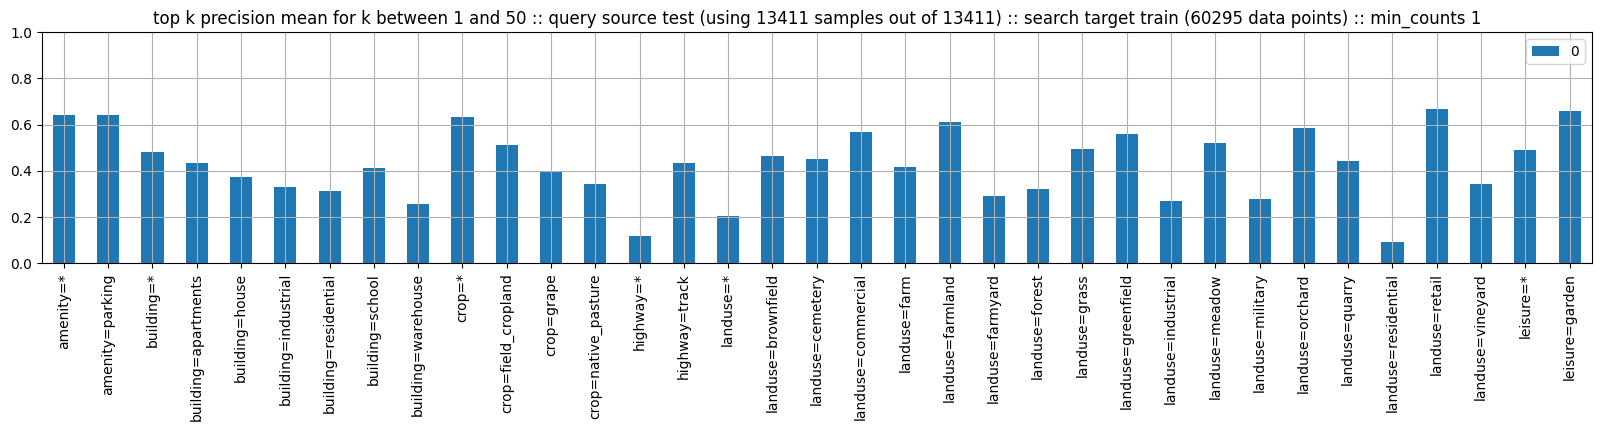

In [114]:
compute_topk_precision_mean(query_source=query_source, 
                            search_target=search_target, 
                            mink=1, 
                            maxk=50,
                            min_counts=1,
                            n_samples=None,
                            plot=True);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7136 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 8386 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 11186 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 12736 tasks    

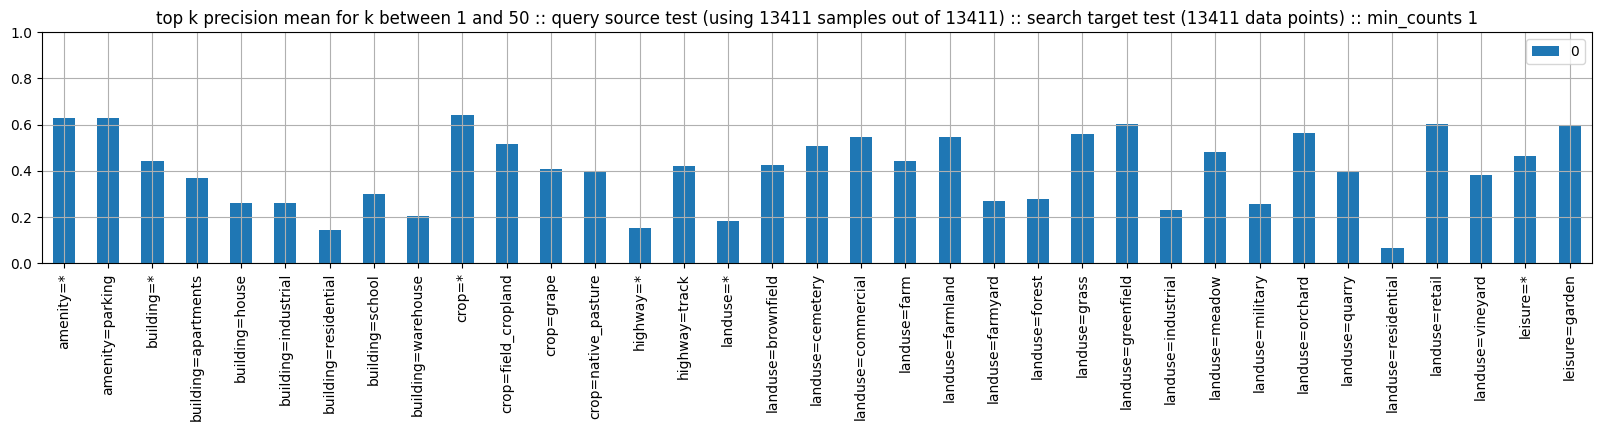

In [115]:
compute_topk_precision_mean(query_source=query_source, 
                            search_target='test', 
                            mink=1, 
                            maxk=50,
                            min_counts=1,
                            n_samples=None,
                            plot=True);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   44.6s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 7136 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 8386 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 9736 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 11186 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 12736 tasks    

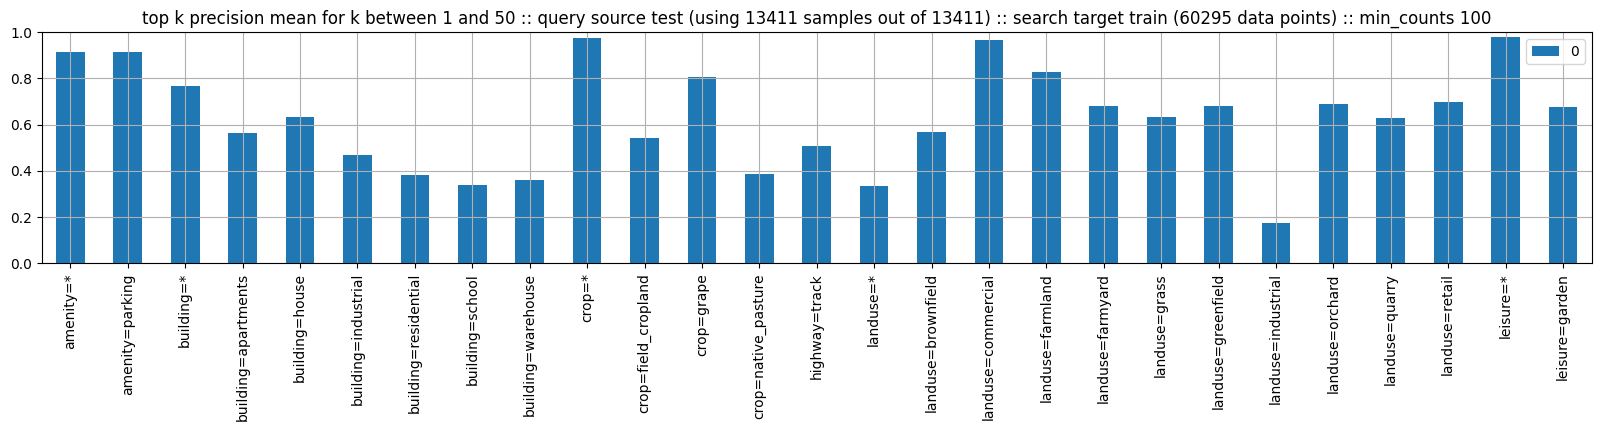

In [116]:
compute_topk_precision_mean(query_source=query_source, 
                            search_target=search_target, 
                            mink=1, 
                            maxk=50,
                            min_counts=100,
                            n_samples=None,
                            plot=True);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  4.4min finished


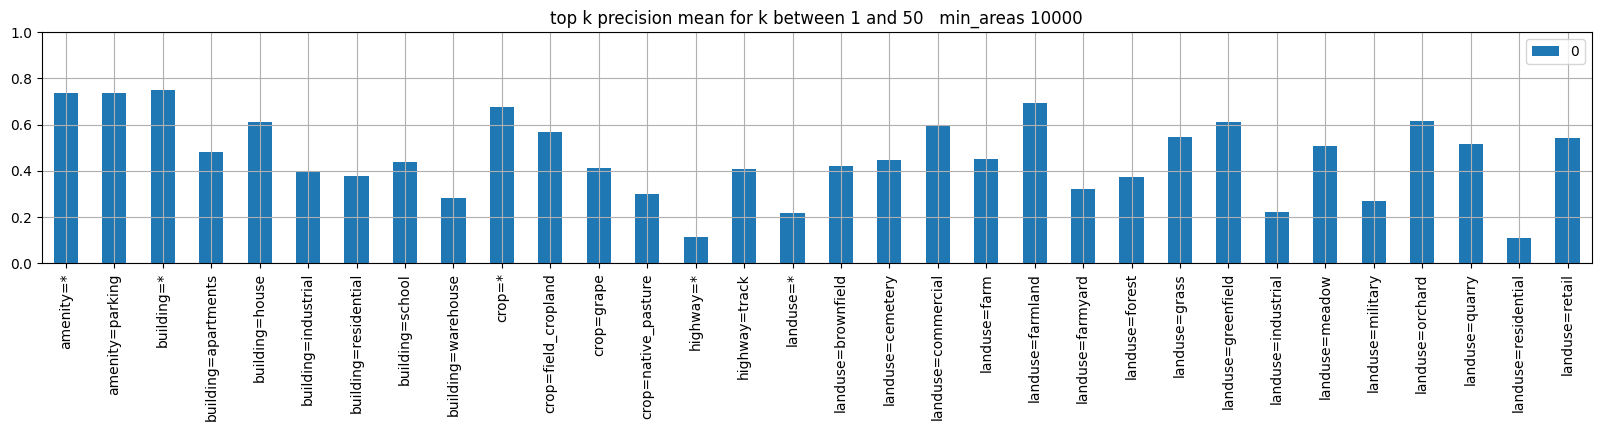

In [98]:
compute_topk_precision_mean(query_source=query_source, 
                            search_target=search_target, 
                            mink=1, 
                            maxk=50,
                            min_areas=10000,
                            n_samples=5000,
                            plot=True);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1736 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2386 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3136 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3986 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4936 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  4.5min finished


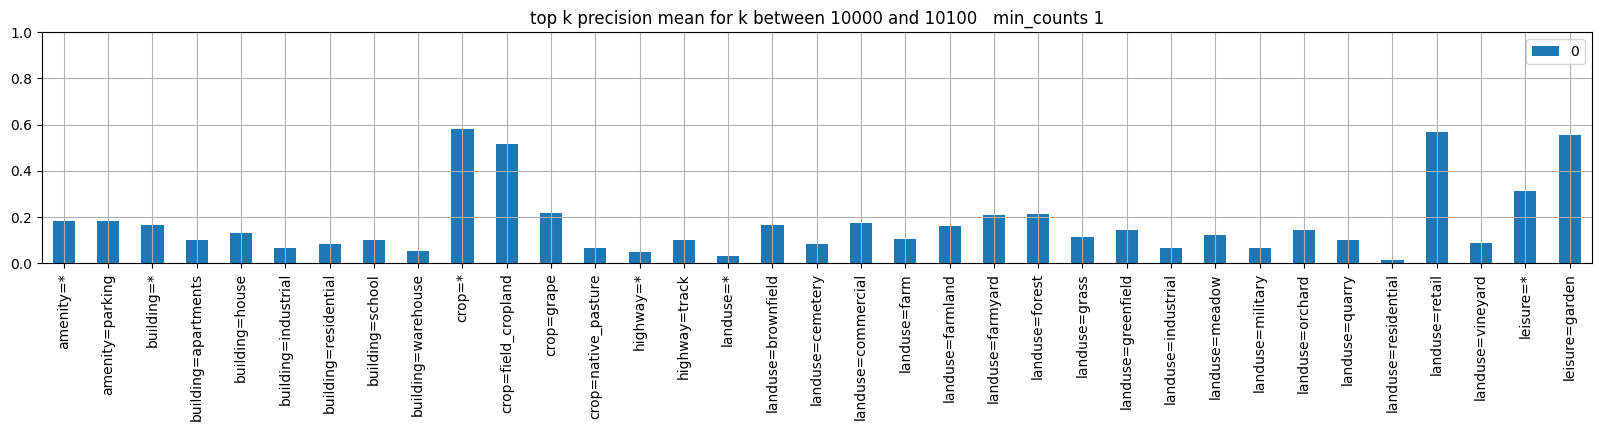

In [99]:
compute_topk_precision_mean(query_source=query_source, 
                            search_target=search_target, 
                            mink=10000, 
                            maxk=10100,
                            min_counts=1,
                            n_samples=5000,
                            plot=True);